In [48]:
import tensorflow as tf
import torch
import numpy as np
import math
import random
from graphviz import Digraph
import matplotlib.pyplot as plt
%matplotlib inline

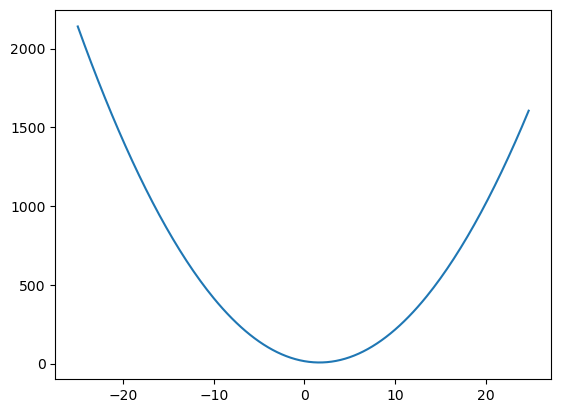

In [49]:
def f(x):
    return 3*x**2 - 10*x + 15

xs = np.arange(-25, 25, 0.25)
ys = f(xs)

plt.plot(xs, ys)

## Building the Value node Data Structure

In [95]:
# Data Structure to store Nodes

class Value:

     def __init__(self, data, _children = (), _op = '', label = '') -> None:
            self.data = float(data)
            self._prev = set(_children)
            self.grad = 0.0
            self._backward = lambda : None
            self._op = _op
            self.label = label

     def __repr__(self) -> str:
     
        return f"Value(data={self.data})"
    
     def __add__(self, other):
         
          # In case Value(2.0) + 1 is performed
          if not isinstance(other, Value):
              other = Value(other)
         
          out = Value(self.data + other.data, (self, other), '+')
         
          def _backward():
              self.grad += 1.0 * out.grad
              other.grad += 1.0 * out.grad

          out._backward = _backward
          return out
     
     def __sub__(self, other):
         
          return self + (-other)
     
     def __neg__(self):
          return self * -1

    
     def __mul__(self, other):
         
         if not isinstance(other, Value):
              other = Value(other)

         out = Value(self.data * other.data, (self, other), '*')

         def _backward():
              self.grad += other.data * out.grad
              other.grad += self.data * out.grad
          
         out._backward = _backward
         return out
    
     def tanh(self):
         x = self.data
         t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
         out = Value(t, (self,), _op = 'tanh')

         def _backward():
              self.grad += (1 - t**2)  * out.grad
         out._backward = _backward
         return out
     
     def exp(self):

          x = self.data
          out = Value(math.exp(x), (self,), 'exp')

          def _backward():
               self.grad += out.data * out.grad
          out._backward = _backward

          return out
     
     def __pow__(self, other):

          assert isinstance(other, (int, float))
          out = Value(self.data ** other, (self,), 'pow')

          def _backward():
               self.grad += other * (self ** other - 1) * out.grad

          out._backward = _backward
    
          return out
     
     def __truediv__(self, other):
          return self * other**-1

     def backward(self):

          # Base case
          self.grad = 1.0

          # Creating a topological graph
          topo = []
          visited = set()

          def dfs(node):
               if node not in visited:
                    visited.add(node)
                    for child in node._prev:
                         dfs(child)
                    topo.append(node)

          try:
               print("Finiding Topological ordering")
               dfs(self)
               print("Topological ordering established")
          except Exception as e:
               print(f"Error while finding Topological ordering {e}")

          # Finding gradients for each node
          try:
               for node in topo[::-1]:
                    node._backward()
          except Exception as e:
               print(f"Error while calculating gradients {e}")

In [96]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [102]:
# Neuron Forward Pass
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(-3.0, label='w2')
b = Value(4.7, label='b')

x1w1 = x1 * w1 ; x1w1.label = 'x1w1'
x2w2 = x2 * w2 ; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b ; n.label = 'n'
o = n.tanh() ; o.label = 'o'
o

Value(data=-0.8617231593133062)

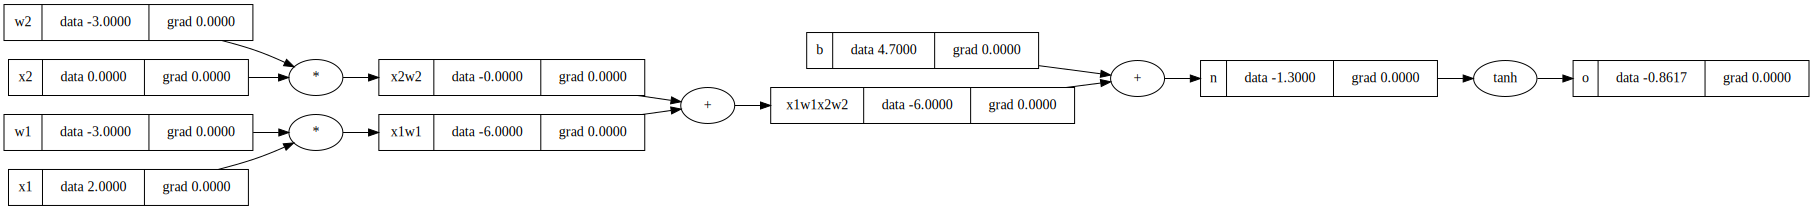

In [103]:
# Visualize
draw_dot(o)

In [104]:
# BackPropogation
o.backward()

Finiding Topological ordering
Topological ordering established


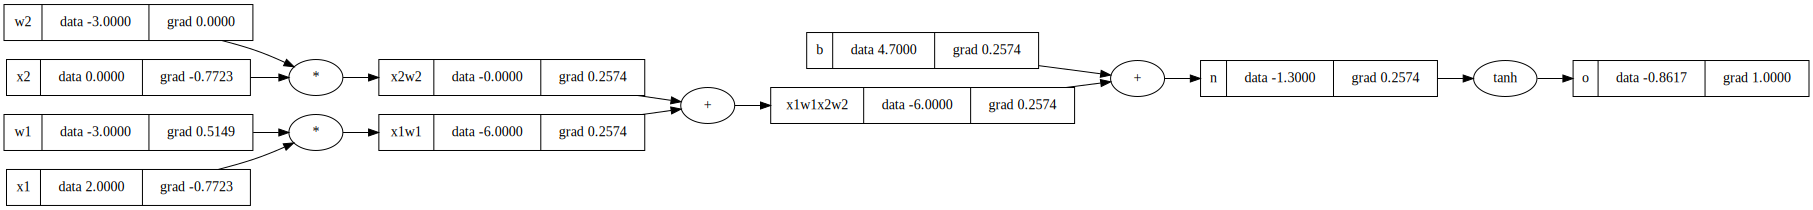

In [105]:
# Visualize after backprop
draw_dot(o)

## Building the Neural Network Structure

In [ ]:
class Neuron:

    def __init__(self,nin) -> None:

        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, -1))